In [1]:
"""
Example: wrap up task with GridSearchBase for hyperparameter search and plot results
"""
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from echoes.model_selection import GridSearchBase
from echoes.plotting import set_mystyle
from echoes.tasks import MemoryCapacity

set_mystyle()


class GridSearchMemoryCapacity(GridSearchBase):
    def _eval_gridpoint(self, esn_params, data):
        """data: placeholder for consistency with the function signature"""
        # Echo state network parameters (after Jaeger)
        n_reservoir = esn_params["n_reservoir"]
        W = np.random.choice([0, .47, -.47], p=[.8, .1, .1], size=(n_reservoir, n_reservoir))
        W_in = np.random.choice([.1, -.1], p=[.5, .5], size=(n_reservoir, 2))
        # Task parameters (after Jaeger)
        inputs_func=np.random.uniform   
        inputs_params={"low":-.5, "high":.5, "size":200}
        lags = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]
        
        esn_params_fix = dict(
            n_inputs=1,
            n_reservoir=n_reservoir,
            n_outputs=len(lags),  # automatically decided based on lags
            n_transient=100,
            regression_method="pinv",    
            W=W,
            W_in=W_in,
        )    
        esn_params = {**esn_params_fix, **esn_params}
        # Initialize the task object
        mc = MemoryCapacity(
            inputs_func=inputs_func,                     
            inputs_params=inputs_params,  
            esn_params=esn_params,
            lags=lags
        ).fit_predict()  # Run the task

        return -mc.memory_capacity_   #make negative - score is loss!

param_grid = dict(
    n_reservoir=[20, 30, 40, 50],
    spectral_radius=list(np.linspace(.7, .99, 100)),
    bias=[0, .25, .5, 1],
    fit_only_states=[True, False]
)

grid = GridSearchMemoryCapacity(param_grid=param_grid).fit(None, None)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  67 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 1157 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-2)]: Done 3083 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-2)]: Done 3200 out of 3200 | elapsed:   11.1s finished


In [2]:
grid.best_params_, grid.best_score_

({'bias': 0,
  'fit_only_states': True,
  'n_reservoir': 50,
  'spectral_radius': 0.8347474747474747},
 -5.9687505363515605)

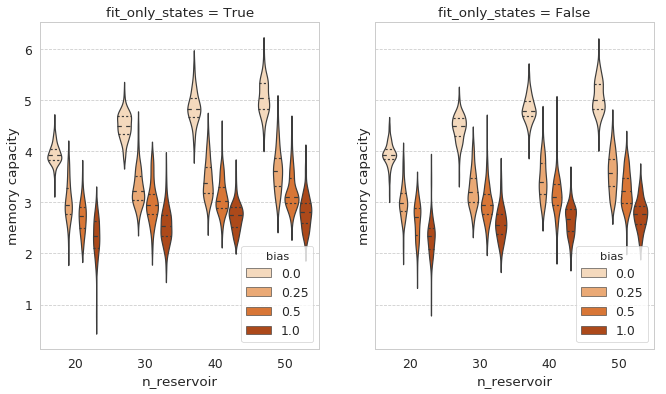

In [4]:
data = grid.to_dataframe()
data["memory capacity"] = -data["scores"] # revert to memory capacity

fig, axes = plt.subplots(figsize=(11, 6), ncols=2, sharey=True)
for ax, onlystates in zip(axes, (True, False)): 
    sns.violinplot(
        x="n_reservoir", 
        y="memory capacity", 
        data=data[data.fit_only_states == onlystates], 
        hue="bias", 
        ax=ax,
        inner="quartile", 
        palette="Oranges",)
    
    ax.set_title(f"fit_only_states = {onlystates}")